In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility



In [2]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

resolution = [1920,1080] 

import sionna

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

In [3]:
# Load integrated scene
scene = load_scene('./scene/aachen.xml')

for mat in scene.radio_materials.values():
    mat.scattering_coefficient = 1./tf.sqrt(3.)

myCamera = Camera(name="camera", position=[300,350,150],look_at=[0,0,0])
scene.add(myCamera)

scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

scene.frequency = 2.14e9
scene.synthetic_array = True

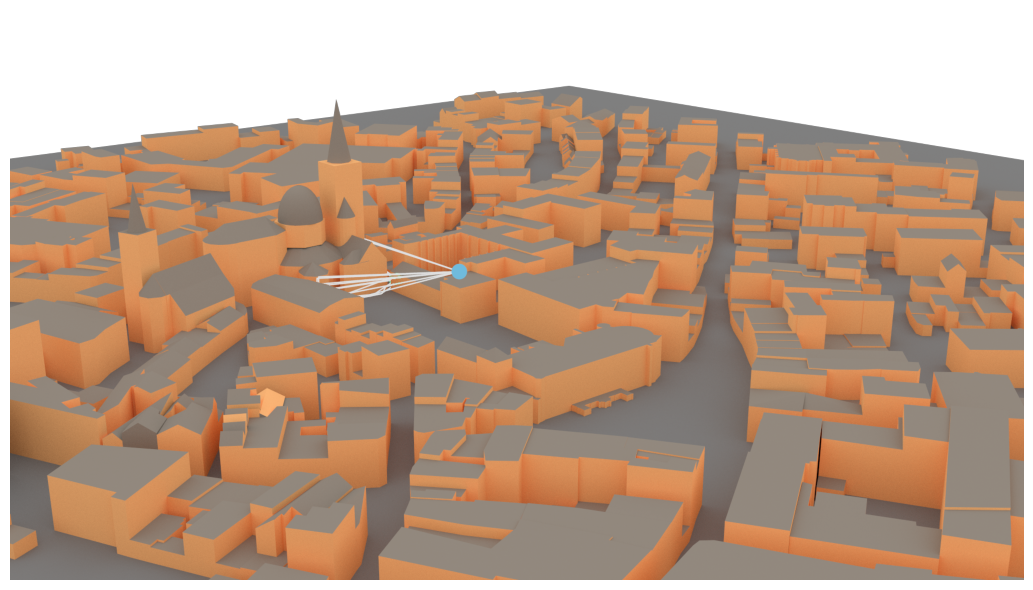

In [4]:
# Create array of receivers and transmitters
rx = Receiver(name="rx",
              position=[30,-40,3],
              orientation=[0,0,0])

scene.add(rx)

tx = Transmitter(name="tx",
                 position=[38,12,20],
                 look_at=rx)

scene.add(tx)

paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)

scene.render("camera", paths=paths, show_devices=True, show_paths=True, resolution=resolution)

scene.remove("tx")
scene.remove("rx")

In [5]:
rx = Receiver(name="rx",
              position=[30,-40,3],
              orientation=[0,0,0])

scene.add(rx)

tx = Transmitter(name="tx",
                 position=[38,12,20],
                 orientation=tf.Variable([0., 0., np.pi/2], treinable=True))

scene.add(tx)

cm_before = scene.coverage_map(max_depth=5,
                               diffraction=True, 
                               cm_cell_size=(5., 5.), 
                               combining_vec=None,
                               precoding_vec=None,
                               num_samples=int(1e6),
                               check_scene=False) 




In [6]:
target_orientation = np.array([0., 0., 0.])
target_center = scene.receivers["rx"].position.numpy()
target_size = np.array([50., 50.])
cm_cell_size = np.array([2., 2.])

optimizer = tf.keras.optimizers.RMSprop(0.1)

num_steps = 10

def train_step():
    with tf.GradientTape() as tape:
        
        tape.watch(scene.transmitters["tx"].orientation)
        target_cm = scene.coverage_map(cm_center=target_center,
                                       cm_orientation=target_orientation, 
                                       cm_size=target_size,
                                       cm_cell_size=cm_cell_size,
                                       diffraction=True,
                                       check_scene=False) 
        
        scaling = 1e6
        rate = tf.reduce_mean(tf.math.log(1. + target_cm.as_tensor()*scaling))/tf.math.log(2.)
        loss = -rate
    
        grads = tape.gradient(loss, tape.watched_variables())
        
        optimizer.apply_gradients(zip(grads, tape.watched_variables()))
        return rate

for step in range(num_steps):       
    rate = train_step()
    print(f"Training step {step} - Rate: {rate.numpy():.2E} bit - tx orientation: {scene.transmitters['tx'].orientation.numpy()}", end='\r')


In [7]:
# Create new camera
tx_pos = scene.transmitters["tx"].position.numpy()
bird_pos = tx_pos.copy()
bird_pos[-1] = 750 
bird_pos[-2]-= 0.01 

# Create new camera
bird_cam = Camera("birds_view", position=bird_pos, look_at=tx_pos)

scene.add(bird_cam)

In [8]:
cm_after = scene.coverage_map(max_depth=5,
                               diffraction=True,
                               cm_cell_size=(5., 5.), 
                               combining_vec=None,
                               precoding_vec=None,
                               num_samples=int(1e6),
                               check_scene=False) 

Text(0.5, 0.98, 'After')

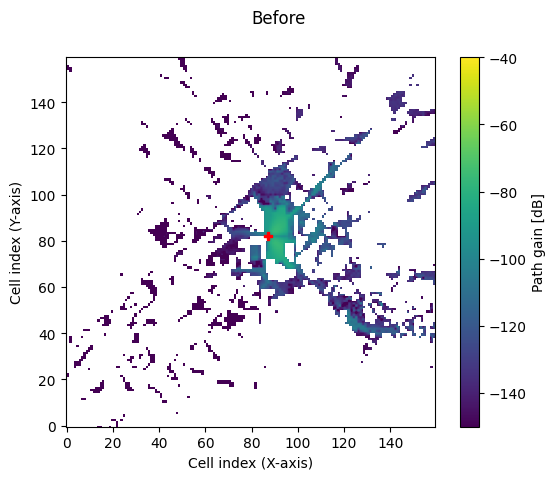

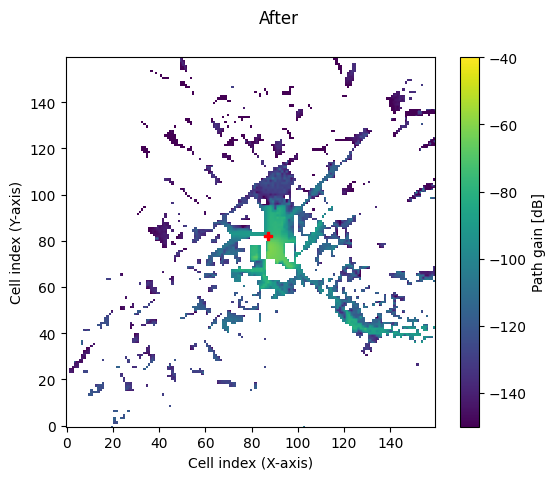

In [9]:
fig = cm_before.show(vmin=-150, vmax=-40)
fig.suptitle("Before")

fig = cm_after.show(vmin=-150, vmax=-40)
fig.suptitle("After")
